In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import os
import cv2

In [30]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.utils import use_named_args

In [4]:
DIR = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
classes = [i for i in os.listdir(DIR) if '.' not in i]                     
classes

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

### Đọc dữ liệu

In [8]:
data = []
# path = 'D:\study-hk2\ML\ML\classification_fish\data\Fish_Dataset' 
path = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder, folder)
    for i in range(1, 1001):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data.append([img, folder])

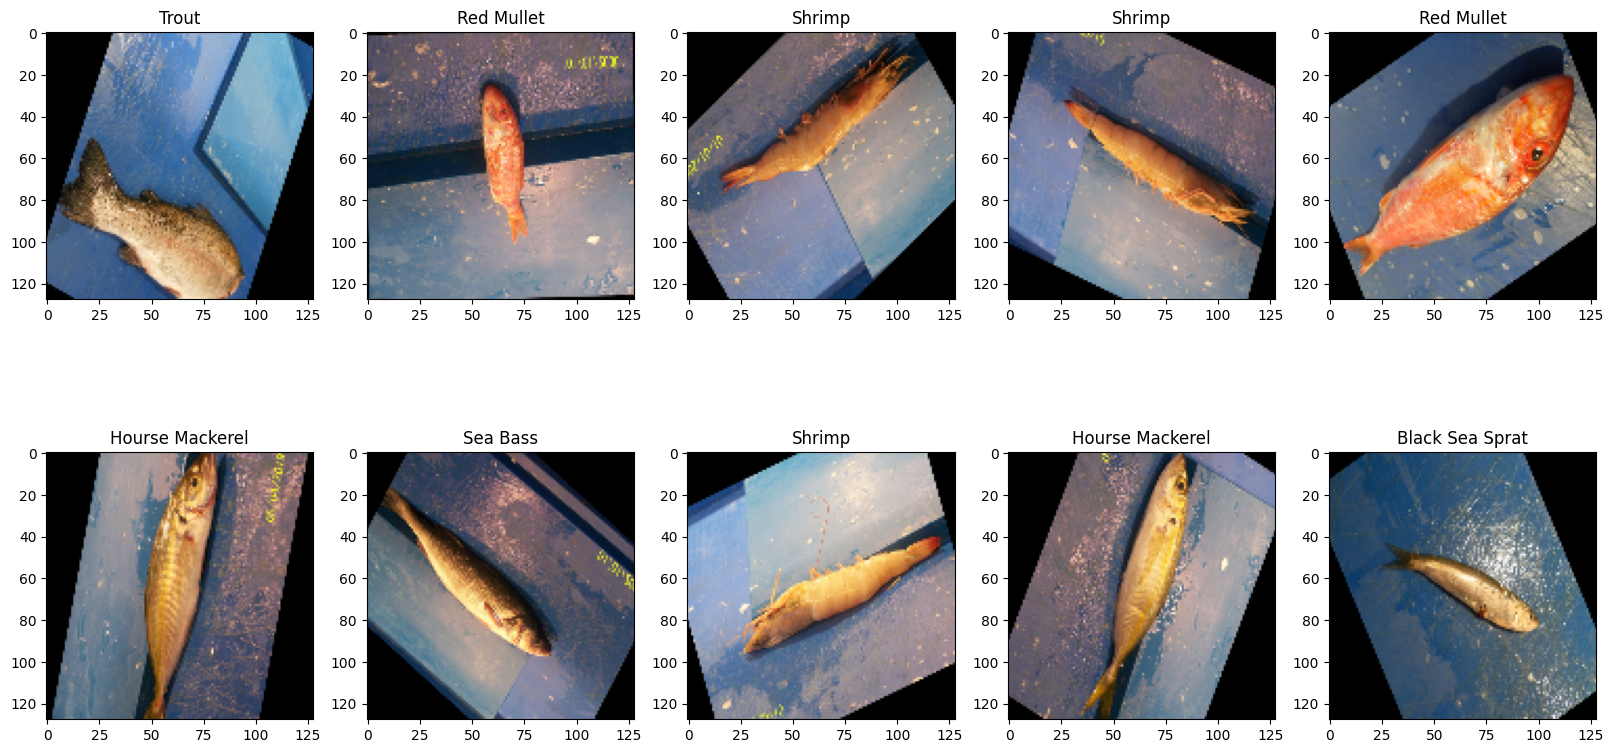

In [10]:
# in ra một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    j = np.random.randint(0, 8970)
    plt.imshow(data[j+i][0])
    plt.title(data[j+i][1])

In [11]:
# tạo image và label từ data
images = []
labels = []
for image, label in data:
    images.append(image)
    labels.append(label)

In [12]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [13]:
labels = tf.keras.utils.to_categorical(labels, num_classes=9)
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [14]:
# reshape images
images = np.array(images)
images = images.reshape(images.shape[0], 128, 128, 3)
images.shape

(9000, 128, 128, 3)

In [15]:
# chuẩn hóa images
images = images.astype('float32') / 255.0

### Chia dữ liệu Train và Validation

In [16]:
# chia train, validation sao cho các lớp có số lượng ảnh tương đương nhau
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=1000, stratify=labels)

train_images.shape, val_images.shape, train_labels.shape, val_labels.shape

((8000, 128, 128, 3), (1000, 128, 128, 3), (8000, 9), (1000, 9))

In [17]:
# đếm số lượng ảnh của mỗi lớp trong tập train
unique, counts = np.unique(np.argmax(train_labels, axis=1), return_counts=True)
dict(zip(unique, counts))

{0: 889, 1: 888, 2: 889, 3: 889, 4: 889, 5: 889, 6: 889, 7: 889, 8: 889}

### Dữ liệu Test

In [19]:
data_test = []
path = "D:\\study\\machine_learning\\classification_fish\\data\\NA_Fish_Dataset"
# path = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset'
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder)
    num_images = len(os.listdir(folder_path))  # Đếm số lượng ảnh trong thư mục
    for i in range(1, num_images + 1):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data_test.append([img, folder])

In [20]:
# shuffle data_test
import random
random.shuffle(data_test)

In [21]:
# tạo image và label từ data_test
test_images = []
test_labels = []
for image, label in data_test:
    test_images.append(image)
    test_labels.append(label)

In [22]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test_labels = le.fit_transform(test_labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [23]:
test_labels  = tf.keras.utils.to_categorical(test_labels , num_classes=9)
test_labels 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
# reshape images
test_images = np.array(test_images)
# images = images.reshape(images.shape[0], 150, 150, 3)
test_images = test_images.reshape(test_images.shape[0], 128, 128, 3)
test_images.shape

(430, 128, 128, 3)

In [26]:
test_images = test_images.astype('float32') / 255.0

### Xây dựng Model

In [28]:
h = train_images.shape[1]
w = train_images.shape[2]
c = train_images.shape[3]

In [40]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(h, w, c)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (1,1), padding="same", activation="relu"))
model.add(Conv2D(64, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), padding="same", activation="relu"))
model.add(Conv2D(128, (5,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [42]:
callbacks = [ModelCheckpoint('model2.hdf5', monitor='val_loss', verbose=2, save_best_only=True, mode='min')]
history = model.fit(train_images ,train_labels, batch_size=32, epochs=15, verbose=1, validation_data=(val_images, val_labels), callbacks= [callbacks])

Epoch 1/15
  3/250 [..............................] - ETA: 3:22 - loss: 1.9912 - accuracy: 0.3646

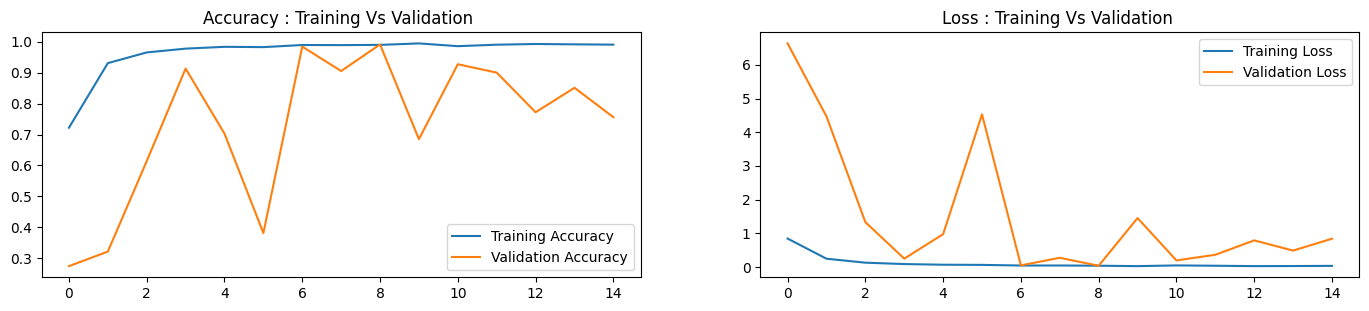

In [33]:
accuracy = history.history['accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(15), accuracy, label='Training Accuracy')
plt.plot(range(15), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy : Training Vs Validation ')

plt.subplot(2, 2, 2)
plt.plot(range(15), loss, label='Training Loss')
plt.plot(range(15), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show();

In [34]:
model = load_model('model2.hdf5')

In [35]:
result = model.evaluate(x=val_images,y=val_labels)

32/32 [==============================] - 5s 137ms/step - loss: 0.0351 - accuracy: 0.9910


In [36]:
result = model.evaluate(x=test_images,y=test_labels)

14/14 [==============================] - 2s 138ms/step - loss: 0.6574 - accuracy: 0.8256


In [37]:
y_pred = model.predict(x=test_images)

y_pred_classes = np.argmax(y_pred,axis=1)

y_true = np.argmax(test_labels,axis=1)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred_classes)

14/14 [==============================] - 2s 141ms/step


Text(0.5, 23.52222222222222, 'Predicted label')

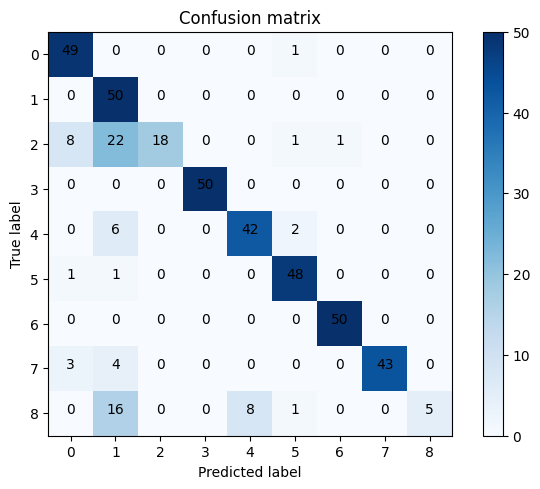

In [38]:
classes = 9

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes))
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(classes), range(classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > 100 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [39]:
# tính accuracy, recall, precision
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred_classes)
recall = recall_score(y_true=y_true, y_pred=y_pred_classes, average="weighted")
precision = precision_score(y_true=y_true, y_pred=y_pred_classes, average="weighted")

print("Accuracy: {0:.2%}, Recall: {1:.2%}, Precision: {2:.2%}".format(accuracy, recall, precision))

Accuracy: 82.56%, Recall: 82.56%, Precision: 88.77%


---

In [ ]:
----------------------------------------------------------------------------------------------------------------------------

#### Create CNN

In [22]:
def create_cnn(learning_rate, num_dense_layers, num_dense_nodes, dropout_rate):
    model = Sequential()

    model.add(Conv2D(kernel_size=3, strides=2, filters=32, padding="same", activation='relu', name="layer_conv1"))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Conv2D(kernel_size=3, strides=2, filters=64, padding="same", activation='relu', name="layer_conv2"))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Conv2D(kernel_size=3, strides=1, filters=128, padding="same", activation='relu', name="layer_conv3"))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Flatten())

    for i in range(num_dense_layers):
        name = f"layer_dense_{i+1}"
        model.add(Dense(num_dense_nodes, activation='relu', name=name))
        model.add(Dropout(rate=dropout_rate))
    
    model.add(Dense(9, activation="softmax"))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

#### Xác định Hyperparameters

In [23]:
# xác định các hyperparameter
dim_learning_rate = Real(low=1e-6, high=1e-2, prior="log-uniform", name="learning_rate")
dim_num_dense_layers = Integer(low=1, high=5, name="num_dense_layers")
dim_num_dense_nodes = Integer(low=5, high=512, name="num_dense_nodes")
dim_dropout_rate = Real(low=0.2, high=0.5, prior="log-uniform", name="dropout_rate")

In [24]:
param_grid = [
    dim_learning_rate,
    dim_num_dense_layers,
    dim_num_dense_nodes,
    dim_dropout_rate
]

In [25]:
path_best_model = "cnn_model2.h5"
best_accuracy = 0.0

In [32]:
@use_named_args(param_grid)
def objective(learning_rate, num_dense_layers, num_dense_nodes, dropout_rate):
    print("learning rate: {0:.1e}".format(learning_rate))
    print("num_dense_layers:", num_dense_layers)
    print("num_dense_nodes:", num_dense_nodes)
    print()

    model = create_cnn(learning_rate=learning_rate,
                          num_dense_layers=num_dense_layers,
                            num_dense_nodes=num_dense_nodes,
                            dropout_rate=dropout_rate)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                                patience=2,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.00001)
    history = model.fit(x=train_images,y=train_labels,epochs=10,batch_size=64,validation_data=(val_images, val_labels),callbacks=[learning_rate_reduction])

    accuracy = history.history['val_accuracy'][-1]

    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    global best_accuracy
    if accuracy > best_accuracy:
        model.save(path_best_model)
        best_accuracy = accuracy

    del model

    return -accuracy

In [33]:
default_parameters = [1e-5, 1, 16, 0.2]
objective(x=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16

Epoch 1/10
125/125 [==============================] - 45s 356ms/step - loss: 2.1932 - accuracy: 0.1429 - val_loss: 2.1903 - val_accuracy: 0.1830 - lr: 1.0000e-05
Epoch 2/10
125/125 [==============================] - 38s 302ms/step - loss: 2.1865 - accuracy: 0.1749 - val_loss: 2.1832 - val_accuracy: 0.2010 - lr: 1.0000e-05
Epoch 3/10
125/125 [==============================] - 34s 275ms/step - loss: 2.1786 - accuracy: 0.1961 - val_loss: 2.1737 - val_accuracy: 0.2150 - lr: 1.0000e-05
Epoch 4/10
125/125 [==============================] - 38s 304ms/step - loss: 2.1661 - accuracy: 0.2105 - val_loss: 2.1592 - val_accuracy: 0.2380 - lr: 1.0000e-05
Epoch 5/10
125/125 [==============================] - 40s 322ms/step - loss: 2.1483 - accuracy: 0.2410 - val_loss: 2.1378 - val_accuracy: 0.2560 - lr: 1.0000e-05
Epoch 6/10
125/125 [==============================] - 38s 302ms/step - loss: 2.1248 - accuracy: 0.2558 - val_loss: 2.1088 - va

-0.34200000762939453

In [34]:
model = load_model(path_best_model)

In [35]:
result = model.evaluate(x=val_images,y=val_labels)

32/32 [==============================] - 1s 33ms/step - loss: 1.7632 - accuracy: 0.3870


In [36]:
y_pred = model.predict(x=test_images)

y_pred_classes = np.argmax(y_pred,axis=1)

y_true = np.argmax(test_labels,axis=1)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred_classes)

14/14 [==============================] - 1s 39ms/step


Text(0.5, 23.52222222222222, 'Predicted label')

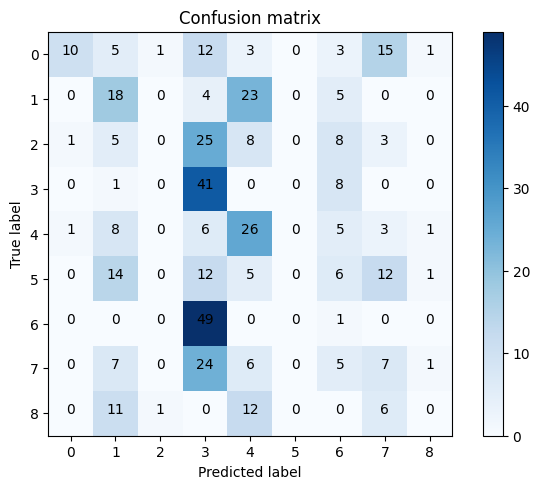

In [37]:
classes = 9

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes))
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(classes), range(classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > 100 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [38]:
# tính accuracy, recall, precision
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred_classes)
recall = recall_score(y_true=y_true, y_pred=y_pred_classes, average="weighted")
precision = precision_score(y_true=y_true, y_pred=y_pred_classes, average="weighted")

print("Accuracy: {0:.2%}, Recall: {1:.2%}, Precision: {2:.2%}".format(accuracy, recall, precision))

Accuracy: 23.95%, Recall: 23.95%, Precision: 21.17%


c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---

In [39]:
gp_ = gp_minimize(func=objective,
                    dimensions=param_grid,
                    x0 = default_parameters,
                    acq_func="EI",
                    n_calls=30,
                    random_state=0)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16

Epoch 1/10
125/125 [==============================] - 42s 331ms/step - loss: 2.1908 - accuracy: 0.1531 - val_loss: 2.1827 - val_accuracy: 0.2090 - lr: 1.0000e-05
Epoch 2/10
125/125 [==============================] - 32s 260ms/step - loss: 2.1749 - accuracy: 0.2076 - val_loss: 2.1647 - val_accuracy: 0.2500 - lr: 1.0000e-05
Epoch 3/10
125/125 [==============================] - 32s 257ms/step - loss: 2.1538 - accuracy: 0.2206 - val_loss: 2.1397 - val_accuracy: 0.2790 - lr: 1.0000e-05
Epoch 4/10
125/125 [==============================] - 32s 257ms/step - loss: 2.1239 - accuracy: 0.2456 - val_loss: 2.1052 - val_accuracy: 0.2790 - lr: 1.0000e-05
Epoch 5/10
125/125 [==============================] - 32s 257ms/step - loss: 2.0885 - accuracy: 0.2594 - val_loss: 2.0656 - val_accuracy: 0.2980 - lr: 1.0000e-05
Epoch 6/10
125/125 [==============================] - 32s 258ms/step - loss: 2.0500 - accuracy: 0.2689 - val_loss: 2.0230 - va

In [40]:
"Best score=%.4f" % gp_.fun

'Best score=-0.9950'

In [41]:
print("""Best parameters:
=========================
- learning_rate=%.6f
- num_dense_layers=%d
- num_dense_nodes=%d
- activation=%s""" % (gp_.x[0], gp_.x[1], gp_.x[2], gp_.x[3]))

Best parameters:
- learning_rate=0.000523
- num_dense_layers=3
- num_dense_nodes=378
- activation=0.5


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

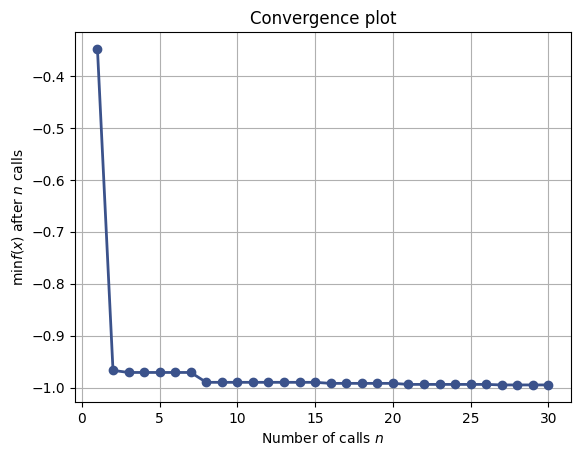

In [42]:
plot_convergence(gp_)

In [43]:
dim_names = ["learning_rate", "num_dense_layers", "num_dense_nodes", "dropout_rate"]

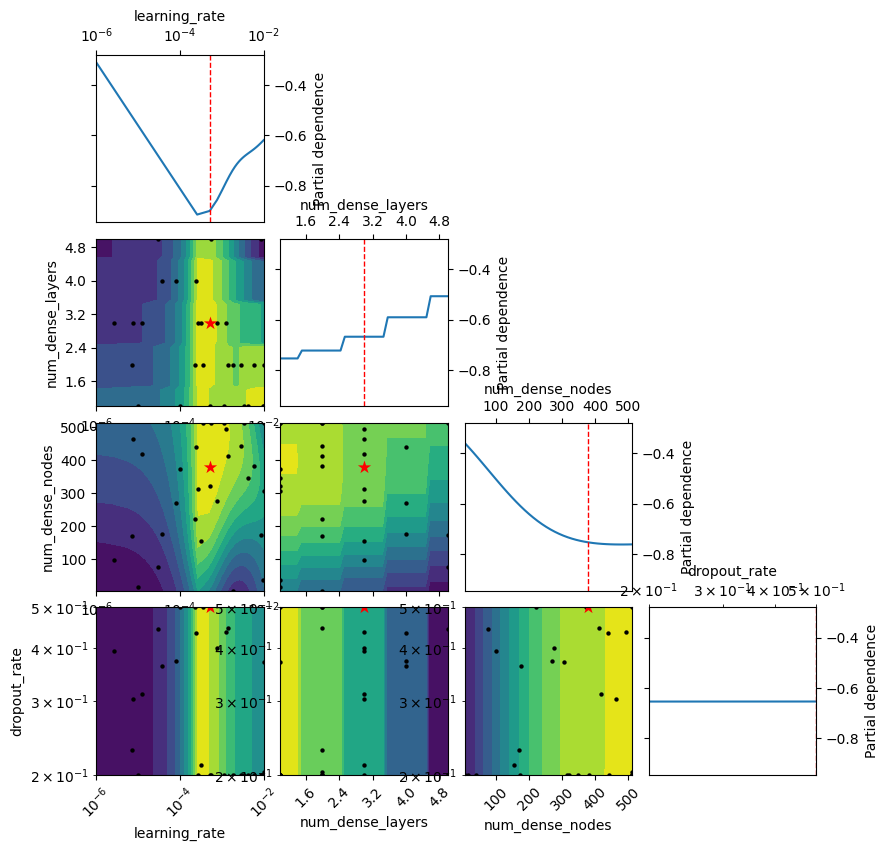

In [44]:
plot_objective(result=gp_, dimensions=dim_names)
plt.show()

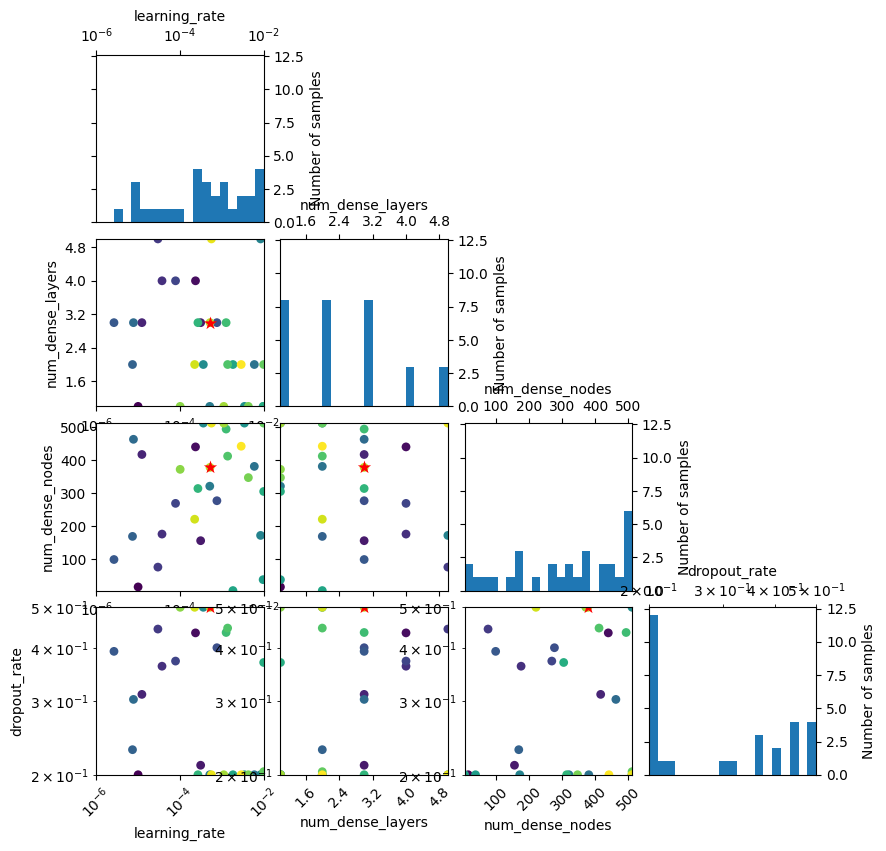

In [45]:
plot_evaluations(result=gp_, dimensions=dim_names)
plt.show()

---

In [70]:
model = load_model(path_best_model)

In [71]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_conv1 (Conv2D)        (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 layer_conv2 (Conv2D)        (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 layer_conv3 (Conv2D)        (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_86 (MaxPoolin  (None, 7, 7, 128)      

In [73]:
result = model.evaluate(x=val_images,y=val_labels)

32/32 [==============================] - 2s 42ms/step - loss: 0.0180 - accuracy: 0.9950


In [82]:
history = model.fit(train_images ,train_labels,epochs=10, validation_data=(val_images, val_labels))

Epoch 1/10
250/250 [==============================] - 44s 177ms/step - loss: 0.0854 - accuracy: 0.9759 - val_loss: 0.0407 - val_accuracy: 0.9900
Epoch 2/10
250/250 [==============================] - 45s 182ms/step - loss: 0.0696 - accuracy: 0.9789 - val_loss: 0.1152 - val_accuracy: 0.9630
Epoch 3/10
250/250 [==============================] - 44s 176ms/step - loss: 0.0589 - accuracy: 0.9841 - val_loss: 0.0453 - val_accuracy: 0.9860
Epoch 4/10
250/250 [==============================] - 46s 185ms/step - loss: 0.0444 - accuracy: 0.9856 - val_loss: 0.0312 - val_accuracy: 0.9900
Epoch 5/10
250/250 [==============================] - 44s 178ms/step - loss: 0.0429 - accuracy: 0.9880 - val_loss: 0.0752 - val_accuracy: 0.9770
Epoch 6/10
250/250 [==============================] - 45s 181ms/step - loss: 0.0366 - accuracy: 0.9885 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 7/10
250/250 [==============================] - 51s 203ms/step - loss: 0.0557 - accuracy: 0.9841 - val_loss: 0.0378 - val_ac

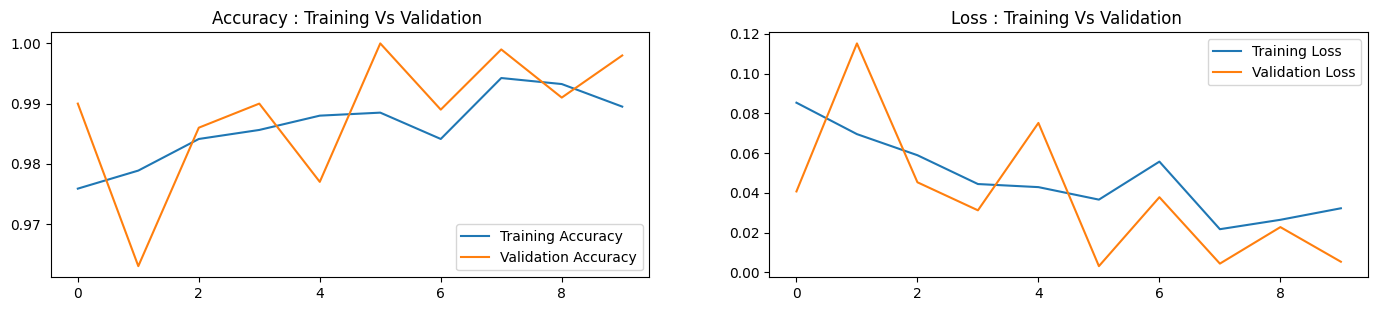

In [83]:
accuracy = history.history['accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(10), accuracy, label='Training Accuracy')
plt.plot(range(10), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy : Training Vs Validation ')

plt.subplot(2, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show();

In [84]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.018012380227446556
accuracy 0.9950000047683716


In [66]:
result = model.evaluate(x=test_images,y=test_labels)

14/14 [==============================] - 1s 39ms/step - loss: 2.2362 - accuracy: 0.5605


In [57]:
y_pred = model.predict(x=test_images)

y_pred_classes = np.argmax(y_pred,axis=1)

y_true = np.argmax(test_labels,axis=1)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred_classes)

14/14 [==============================] - 1s 54ms/step


Text(0.5, 23.52222222222222, 'Predicted label')

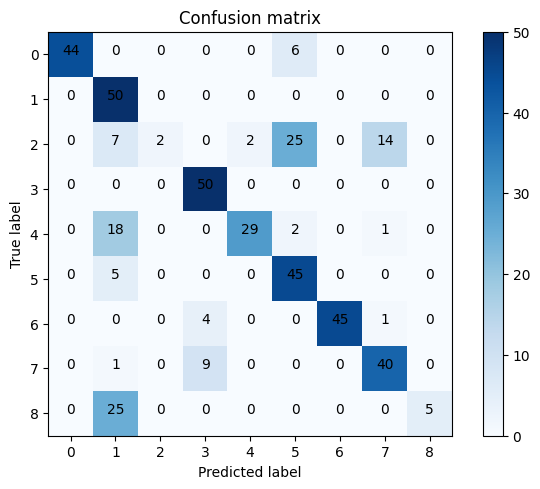

In [67]:
classes = 9

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes))
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(classes), range(classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > 100 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [68]:
# tính accuracy, recall, precision
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred_classes)
recall = recall_score(y_true=y_true, y_pred=y_pred_classes, average="weighted")
precision = precision_score(y_true=y_true, y_pred=y_pred_classes, average="weighted")

print("Accuracy: {0:.2%}, Recall: {1:.2%}, Precision: {2:.2%}".format(accuracy, recall, precision))

Accuracy: 72.09%, Recall: 72.09%, Precision: 82.47%
